# Table of Contents
1 - [Problem Statement](#ps)  
2 - [Overview of Dataset](#dataset)  
3 - [Loading the Data](#load)   
4 - [Exploratory Data Analysis](#eda)   
&emsp;  4.1 - [Data Cleaning: Deduplication](#deduplication)   
5 - [Text Preprocessing Using NLTK](#textprep)  
6 - [Train and Test Split of Data](#split)  
7 - [Ensemble Models](#ens)  
&emsp;  7.1 - [Random Forest(Bagging)](#rf)  
&emsp;  7.2 - [XGBoost (Gradient Boosting)](#xg)    
8 - [Featurization Methods](#vec)  
&emsp;  8.1 - [Bag Of Words(unigram)](#bowuni)   
&emsp;  8.2 - [Bag Of Words(bigram)](#bowbi)  
&emsp;  8.3 - [TF-IDF(unigram)](#tfidfuni)  
&emsp;  8.4 - [TF-IDF(bigram)](#tfidfbi)   
&emsp;  8.5 - [Average Word2Vec](#avgw2v)  
&emsp;  8.6 - [TF-IDF Weighted Word2Vec](#tfidfw2v)  
9 - [Conclusion](#conclusion)

## [1] Problem Statement : <a name="ps"></a>

-  Time Based slicing(100k data points) to split Train Data(70%) and Test Data(30%).
-  Appling ensemble models(both Random Forest and XGBoost) to find the optimal hyperparameters using 10 fold cv :  
&emsp; 1)Bag Of Words  
&emsp; 2)TF-IDF  
&emsp; 2)Average Word2Vec  
&emsp; 2)TF-IDF weighted Word2Vec     
-  Comparsion of various performance metrics obtained by various featurization models.    

## [2] Overview of Dataset : <a name="dataset"></a>

Data Source: https://www.kaggle.com/snap/amazon-fine-food-reviews

The Amazon Fine Food Reviews dataset consists of reviews of fine foods from Amazon.  

Number of reviews: 568,454  
Number of users: 256,059  
Number of products: 74,258  
Timespan: Oct 1999 - Oct 2012  
Number of Attributes/Columns in data: 10  

Attribute Information:

&emsp;1.Id  
&emsp;2.ProductId - unique identifier for the product  
&emsp;3.UserId - unqiue identifier for the user  
&emsp;4.ProfileName  
&emsp;5.HelpfulnessNumerator - number of users who found the review helpful  
&emsp;6.HelpfulnessDenominator - number of users who indicated whether they found the review helpful or not  
&emsp;7.Score - rating between 1 and 5  
&emsp;8.Time - timestamp for the review  
&emsp;9.Summary - brief summary of the review  
&emsp;10.Text - text of the review  

Objective:
Given a review, determine whether the review is positive (Rating of 4 or 5) or negative (rating of 1 or 2).


[Q] How to determine if a review is positive or negative?

[Ans] We could use the Score/Rating. A rating of 4 or 5 could be cosnidered a positive review. A review of 1 or 2 could be considered negative. A review of 3 is nuetral and ignored. This is an approximate and proxy way of determining the polarity (positivity/negativity) of a review.

## [3] Loading the Data : <a name="load"></a>

In order to load the data, we have used the SQLITE dataset as it easier to query the data and visualise the data efficiently.
<br> 

Here as we only want to get the global sentiment of the recommendations (positive or negative), we will purposefully ignore all Scores equal to 3. If the score id above 3, then the recommendation wil be set to "positive". Otherwise, it will be set to "negative".

In [1]:
#Importing the necessary Packages
%matplotlib inline
import warnings
warnings.filterwarnings("ignore")


import time
from tqdm import tqdm
import sqlite3
import pandas as pd
import numpy as np
import nltk
import string
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import TfidfTransformer
from sklearn.feature_extraction.text import TfidfVectorizer
from xgboost import XGBClassifier
from IPython.display import HTML
from collections import OrderedDict


from sklearn.feature_extraction.text import CountVectorizer 
from sklearn.metrics import confusion_matrix
from sklearn import metrics
from sklearn.metrics import roc_curve, auc
from nltk.stem.porter import PorterStemmer

import re
import string
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.stem.wordnet import WordNetLemmatizer

from gensim.models import Word2Vec
from gensim.models import KeyedVectors
import pickle

In [2]:
import pickle

#dumping an object to file object using dump method
def dumpfile(a,file_Name):
    fileObject = open(file_Name,"wb")
    pickle.dump(a,fileObject,protocol=2)
    fileObject.close()

#loading an object from file object using load method
def loadfile(file_Name):
    fileObject = open(file_Name,"rb")
    b = pickle.load(fileObject)
    return b


In [27]:
# using the SQLite Table to read data.
con = sqlite3.connect('database.sqlite') 


#filtering only positive and negative reviews i.e. 
# not taking into consideration those reviews with Score=3
filtered_data = pd.read_sql_query(""" SELECT * FROM Reviews WHERE Score != 3 """, con) 

In [7]:
# Give reviews with Score>3 a positive rating, and reviews with a score<3 a negative rating.
def partition(x):
    if x < 3:
        return 'negative'
    return 'positive'

#changing reviews with score less than 3 to be positive and vice-versa
actualScore = filtered_data['Score']
positiveNegative = actualScore.map(partition) 
filtered_data['Score'] = positiveNegative

In [8]:
print("Number of datapoints: ",filtered_data.shape[0])
print("Number of attributes/features: ",filtered_data.shape[1])
HTML(filtered_data.head().to_html(index=False))

Number of datapoints:  525814
Number of attributes/features:  10


Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
1,B001E4KFG0,A3SGXH7AUHU8GW,delmartian,1,1,positive,1303862400,Good Quality Dog Food,I have bought several of the Vitality canned d...
2,B00813GRG4,A1D87F6ZCVE5NK,dll pa,0,0,negative,1346976000,Not as Advertised,Product arrived labeled as Jumbo Salted Peanut...
3,B000LQOCH0,ABXLMWJIXXAIN,"Natalia Corres ""Natalia Corres""",1,1,positive,1219017600,"""Delight"" says it all",This is a confection that has been around a fe...
4,B000UA0QIQ,A395BORC6FGVXV,Karl,3,3,negative,1307923200,Cough Medicine,If you are looking for the secret ingredient i...
5,B006K2ZZ7K,A1UQRSCLF8GW1T,"Michael D. Bigham ""M. Wassir""",0,0,positive,1350777600,Great taffy,Great taffy at a great price. There was a wid...


## [4] Exploratory Data Analysis :<a name="eda"></a>

### [4.1] Data Cleaning: Deduplication <a name="deduplication"></a>
It is observed (as shown in the table below) that the reviews data had many duplicate entries. Hence it was necessary to remove duplicates in order to get unbiased results for the analysis of the data. Following is an example:

<b>Deduplication 1:-</b> As can be seen below the same user has multiple reviews of the with the same values for HelpfulnessNumerator, HelpfulnessDenominator, Score, Time, Summary and Text  and on doing analysis it was found that <br>
<br> 
ProductId=B000HDOPZG was Loacker Quadratini Vanilla Wafer Cookies, 8.82-Ounce Packages (Pack of 8)<br>
<br> 
ProductId=B000HDL1RQ was Loacker Quadratini Lemon Wafer Cookies, 8.82-Ounce Packages (Pack of 8)<br>

It was inferred after analysis that reviews with same parameters other than ProductId belonged to the same product just having different flavour or quantity. Hence in order to reduce redundancy it was decided to eliminate the rows having same parameters.<br>

The method used for the same was that we first sort the data according to ProductId and then just keep the first similar product review and delelte the others. for eg. in the above just the review for ProductId=B000HDL1RQ remains. This method ensures that there is only one representative for each product and deduplication without sorting would lead to possibility of different representatives still existing for the same product.

In [9]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId="AR5J8UI46CURR"
ORDER BY ProductID
""", con)

HTML(display.head().to_html(index=False))

Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
78445,B000HDL1RQ,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
138317,B000HDOPYC,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
138277,B000HDOPYM,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
73791,B000HDOPZG,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...
155049,B000PAQ75C,AR5J8UI46CURR,Geetha Krishnan,2,2,5,1199577600,LOACKER QUADRATINI VANILLA WAFERS,DELICIOUS WAFERS. I FIND THAT EUROPEAN WAFERS ...


In [10]:
#Sorting data according to ProductId in ascending order
sorted_data=filtered_data.sort_values('ProductId', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')

In [11]:
#Deduplication of entries
final=sorted_data.drop_duplicates(subset={"UserId","ProfileName","Time","Text"}, keep='first', inplace=False)
final.shape

(364173, 10)

<b>Deduplication 2:-</b> It was also seen that in two rows given below the value of HelpfulnessNumerator is greater than HelpfulnessDenominator which is not practically possible hence these two rows too are removed from calcualtions

In [51]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND Id=44737 OR Id=64422
ORDER BY ProductID
""", con)

HTML(display.head().to_html(index=False))

Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
64422,B000MIDROQ,A161DK06JJMCYF,"J. E. Stephens ""Jeanne""",3,1,5,1224892800,Bought This for My Son at College,My son loves spaghetti so I didn't hesitate or...
44737,B001EQ55RW,A2V0I904FH7ABY,Ram,3,2,4,1212883200,Pure cocoa taste with crunchy almonds inside,It was almost a 'love at first bite' - the per...


In [52]:
final=final[final.HelpfulnessNumerator<=final.HelpfulnessDenominator]
print(final.shape)

(364171, 10)


<b>Deduplication 3:-</b> It was also seen that a same user has given different reviews for a same product at same time.I think it is normal for a user to give multiple reviews about a product,but that should be in diffrent time.<br>
So,all those rows with same user giving multiple reviews for a same product at same time are considered as duplicate and hence dropped.

In [53]:
display= pd.read_sql_query("""
SELECT *
FROM Reviews
WHERE Score != 3 AND UserId= "A8891HVRDJAM6" 
ORDER BY ProductID
""", con)

HTML(display.head().to_html(index=False))

Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
86221,B000084E6V,A8891HVRDJAM6,"Marfaux ""Marfaux""",33,33,5,1161388800,Dog LOVE these!,We purchase these dinosaurs constantly. For s...
86236,B000084E6V,A8891HVRDJAM6,"Marfaux ""Marfaux""",3,3,5,1161388800,Very entertaining!,These dinos are great for powerful chewers! Ou...


In [54]:
final=final.drop_duplicates(subset={"ProductId","UserId","ProfileName","Time"}, keep='first', inplace=False)
print(final.shape)

(363633, 10)


<b>Deduplication 4:-</b> It was also seen that in few rows with Ids from 150493 to 150529 contain reviews regarding books,not fine foods.So I think these should be also removed from the dataset.
After looking at the productid column, it can be noticed that all the observations for fine foods start with B followed by numbers except for Ids from 150493 to 150529. 
I suppose the reviews for book ‘Chicken soup for the soul’ have gotten into the datset mistakenly as they contain the words “chicken soup.

In [55]:
display = final[final.ProductId == "0006641040"]
HTML(display.head().to_html(index=False))

Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text
150524,0006641040,ACITT7DI6IDDL,shari zychinski,0,0,positive,939340800,EVERY book is educational,this witty little book makes my son laugh at l...
150506,0006641040,A2IW4PEEKO2R0U,Tracy,1,1,positive,1194739200,"Love the book, miss the hard cover version","I grew up reading these Sendak books, and watc..."
150507,0006641040,A1S4A3IQ2MU7V4,"sally sue ""sally sue""",1,1,positive,1191456000,chicken soup with rice months,This is a fun way for children to learn their ...
150508,0006641040,AZGXZ2UUK6X,"Catherine Hallberg ""(Kate)""",1,1,positive,1076025600,a good swingy rhythm for reading aloud,This is a great little book to read aloud- it ...
150509,0006641040,A3CMRKGE0P909G,Teresa,3,4,positive,1018396800,A great way to learn the months,This is a book of poetry about the months of t...


In [56]:
final = final[final.ProductId != "0006641040"]

In [57]:
print("Percentage  of data still remaining : ",(final['Id'].size*1.0)/(filtered_data['Id'].size*1.0)*100)

#Before starting the next phase of preprocessing lets see the number of entries left
print("Number of reviews left after Data Cleaning and Deduplication :")
print(final.shape)

#How many positive and negative reviews are present in our dataset?
final['Score'].value_counts()

Percentage  of data still remaining :  69.14973735959865
Number of reviews left after Data Cleaning and Deduplication :
(363599, 10)


positive    306566
negative     57033
Name: Score, dtype: int64

<b>Observation:-</b>  
It is an imbalanced dataset as the number of positive reviews are way high in number than negative reviews.

## [5] Text Preprocessing Using NLTK : <a name="textprep"></a>

In the Preprocessing phase we do the following in the order below:-

1. Removal of HTML Tags
2. Removal of  any punctuations or limited set of special characters like , or . or # etc.
3. Check if the word is made up of english letters and is not alpha-numeric
4. Check to see if the length of the word is greater than 2 (as it was researched that there is no adjective in 2-letters)
5. Convert the word to lowercase
6. Removal of  Stopwords
7. Finally Snowball Stemming the word <br>

After which we collect the words used to describe positive and negative reviews

### [5.1] Using SQLite Table to load preprocessed data already saved in disk:

In [142]:
# using the SQLite Table to read data.
conn = sqlite3.connect('final.sqlite') 

final = pd.read_sql_query(""" SELECT * FROM Reviews """,conn) 

In [143]:
#Listing out the number of positive and negative reviews
final = final.reset_index(drop=True)
final['Score'].value_counts()

positive    306566
negative     57033
Name: Score, dtype: int64

In [144]:
(final['Score'].value_counts()/len(final['Score']))*100

positive    84.314313
negative    15.685687
Name: Score, dtype: float64

## [6] Train and Test Split of Data : <a name="split"></a>

<b>Sorting the data by Time :</b>

In [145]:
final = final.sample(n = 100000)

final=final.sort_values('Time', axis=0, ascending=True, inplace=False, kind='quicksort', na_position='last')
final.head()

,index,Id,ProductId,UserId,ProfileName,HelpfulnessNumerator,HelpfulnessDenominator,Score,Time,Summary,Text,CleanedText
386,417838,451855,B00004CXX9,AJH6LUC1UT1ON,The Phantom of the Opera,0,0,positive,946857600,FANTASTIC!,Beetlejuice is an excellent and funny movie. K...,beetlejuic excel funni movi keaton hilari wack...
225,346141,374450,B00004CI84,ACJR7EQF9S6FP,Jeremy Robertson,2,3,positive,951523200,Bettlejuice...Bettlejuice...BETTLEJUICE!,What happens when you say his name three times...,happen say name three time michael keaten star...
831,138017,149789,B00004S1C6,A1KXONFPU2XQ5K,Stephanie Manley,26,28,positive,965779200,A must have!,"These are easy to use, they do not make a mess...",easi use not make mess offer vibrant color not...
213,346115,374421,B00004CI84,A1FJOY14X3MUHE,Justin Howard,2,2,positive,966297600,"A fresh, original film from master storyteller...","This is such a great film, I don't even know h...",great film dont even know sum first complet or...
807,138000,149768,B00004S1C5,A7P76IGRZZBFJ,"E. Thompson ""Soooooper Genius""",18,18,positive,975974400,Who Needs Wilton?,I'm sick of scads of nasty toothpicks all over...,sick scad nasti toothpick counter tint concept...


<b>Time Based Slicing :</b>  
-  Diving the data to Train set(first 70% ie older data) and Test  Set(last 30% ie recent data)

In [146]:
from sklearn.model_selection import train_test_split

X = final["CleanedText"].values
y = final["Score"].values
X_train,X_test,y_train,y_test = train_test_split(X, y, test_size = 0.3,shuffle = False)

In [29]:
print("Shape of X_train: ",X_train.shape)
print("Shape of y_train: ",y_train.shape)
print("Shape of X_test: ",X_test.shape)
print("Shape of y_test: ",y_test.shape)

Shape of X_train:  (70000,)
Shape of y_train:  (70000,)
Shape of X_test:  (30000,)
Shape of y_test:  (30000,)


## [7] Ensemble Models : <a name="ens"></a>

### [7.1] Random Forest(Bagging): <a name="rf"></a>
-  Ensemeble model with concept of <b>Bootsrap Sampling,Feature Sampling and Aggregation of baselearners using majority vote</b>.
-  Hyperparameter - <b>No of Baselearners(decission Trees)</b>
-  Baselearners with <b>high varriance and low bias(fully grown trees)</b>
-  Performing 10 fold cross validation(Grid Search) on Train data 
-  Finding the optimal hyperparameters
-  Plotting between CV error/CV Accuracy and No of Baselearners
-  Predicting on Test Data and plotting Confusion Matrix
-  Reporting Performance Metrics

In [4]:
import warnings
warnings.filterwarnings('ignore')


from sklearn.model_selection import TimeSeriesSplit
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_val_score as cv
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix,precision_score,recall_score,f1_score,classification_report
from sklearn.model_selection import GridSearchCV

def RF_model(X_train,y_train):
    
    baselearners=[10,20,30,40,50,60,70,80,100]
    param_rf=dict(n_estimators=baselearners)
   
    #Cross validation using TimeSeriesSplit
    tscv = TimeSeriesSplit(n_splits=10)
    
    
    #using class_weight = "balanced_subsample" to balance the imbalanced nature on the bootstrap sample for every tree grown
    model = RandomForestClassifier(class_weight = "balanced_subsample")
    grid = GridSearchCV(model, param_rf, cv = tscv, scoring = 'f1_weighted')
    grid_estimator = grid.fit(X_train, y_train)
    
    #Finding the optimal hyperparameter
    optimal_baselearners = grid_estimator.best_params_
    
    #Finding the best score
    grid_mean_scores = [i.mean_validation_score for i in grid_estimator.grid_scores_]
    best_score = grid_estimator.best_score_
    
    #CV Scores
    print("\n\033[1mGrid Scores for Model is:\033[0m\n",grid_estimator.grid_scores_)
    print("\n\033[1mBest Parameters:\033[0m ",optimal_baselearners)
    print("\n\033[1mBest F1-Score:\033[0m {} ".format(np.round(best_score,3)))
    
    
    #Plot 
    plt.figure(figsize = (10,6))
    plt.plot(baselearners,grid_mean_scores, 'g-o')
    for xy in zip(baselearners, np.round(grid_mean_scores,3)):
         plt.annotate('(%s %s)' % xy, xy = xy, textcoords = 'data')
    plt.title("CV F1-Score vs No of BaseLearners ", fontsize=20, fontweight='bold')
    plt.xlabel("BaseLearners", fontsize=16)
    plt.ylabel('CV F1-Score', fontsize=16)
    plt.grid('on')
    
    return grid_estimator

In [5]:
def RF_Test(X_test,y_test):
    y_pred = grid_estimator.predict(X_test)
    accuracy = accuracy_score(y_test,y_pred) * 100
    precision = precision_score(y_test,y_pred,average= 'weighted')
    recall = recall_score(y_test,y_pred,average= 'weighted')
    f1= f1_score(y_test,y_pred,average= 'weighted')
    MSE = (1 - (accuracy/100))
    cm = confusion_matrix(y_test, y_pred)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    cm_df = pd.DataFrame(cm,
                         index = ['negative','positive'], 
                        columns = ['negative','positive'])
    sns.heatmap(cm_df, annot=True)
    plt.title('Confusion Matrix')
    plt.ylabel('Actual Label')
    plt.xlabel('Predicted Label')
    plt.show()
    
    print(cm)
    print("\n\033[1mTest Error :\033[0m {}".format(np.round(MSE,3)))
    print("\033[1mTest Accuracy :\033[0m {} %".format(np.round(accuracy,3)))
    print("\033[1mTrue Negative :\033[0m {}".format(tn))
    print("\033[1mFalse Positive :\033[0m {}".format(fp))
    print("\033[1mFalse Negative :\033[0m {}".format(fn))
    print("\033[1mTrue Positive :\033[0m {}".format(tp))
    print("\33[1mPrecission Score :\033[0m {}".format(np.round(precision,3)))
    print("\33[1mRecall Score :\033[0m {}".format(np.round(recall,3)))
    print("\33[1mF1 Score :\033[0m {}".format(np.round(f1,3)))
    print("\n\n")
    
    print('\33[1mClassification Report for Model is :\33[0m')
    classificationreport = classification_report(y_test, y_pred)
    print(classificationreport)

In [6]:
def featureimportance(X_train, y_train, d, vectorizer, n=20):
    clf = RandomForestClassifier(max_depth=d,class_weight="balanced") 
    clf.fit(X_train,y_train)
    
    features=clf.feature_importances_
    index = np.argsort(features)[::-1][:n] 
    
    names = vectorizer.get_feature_names()
    names = np.array(names)
    plt.figure(figsize=(20, 6))
    plt.bar(range(n),features[index])
    plt.xticks(range(n),names[index],rotation=90)
    plt.title("Feature Importance", fontsize=20,fontweight="bold")
    plt.grid('on')
    plt.show()

### [7.2] XGBoost (Gradient Boosting): <a name="xg"></a>
-  Ensemeble model with <b>Additive Combining of Baselearners with concept of fitting pseudo residuals obtained at the previous iteration</b>.
-  Hyperparameter - <b>No of Baselearners(decission Trees), depth, Learningrate</b>
-  Baselearners with <b>high bias and low varriance(shallow trees of very less depth)</b>
-  Performing 10 fold cross validation(Grid Search) on Train data 
-  Finding the optimal hyperparameters
-  Predicting on Test Data and plotting Confusion Matrix
-  Reporting Performance Metrics

In [7]:
import warnings
warnings.filterwarnings('ignore')

import xgboost as xgb
from xgboost.sklearn import XGBClassifier
from sklearn.model_selection import RandomizedSearchCV
import scipy.stats as st


#taking depth between range 1 to 5 for shallow trees(high bias)
param_gb = {"n_estimators":st.randint(3,200),
            "max_depth":st.randint(1,5),
            "learning_rate":st.uniform(0.05,0.5)
}


def XGB_model(X_train,y_train):
    
    #Cross validation using TimeSeriesSplit
    tscv = TimeSeriesSplit(n_splits=10)
    
    
    model = XGBClassifier()
    grid = RandomizedSearchCV(model, param_gb, cv = tscv, scoring = 'f1_weighted')
    random_estimator = grid.fit(X_train, y_train)
    
    #Finding the optimal hyperparameters
    optimal_hyperparameters = random_estimator.best_params_
    
    #Finding the best score
    grid_mean_scores = [i.mean_validation_score for i in random_estimator.grid_scores_]
    best_score = random_estimator.best_score_
    
    #CV Scores
    print("\n\033[1mGrid Scores for Model is:\033[0m\n",random_estimator.grid_scores_)
    print("\n\033[1mBest Parameters:\033[0m ",optimal_hyperparameters)
    print("\n\033[1mBest F1-Score:\033[0m {} ".format(np.round(best_score,3)))
    

    return random_estimator

In [8]:
def XGB_Test(X_test,y_test):
    y_pred = random_estimator.predict(X_test)
    accuracy = accuracy_score(y_test,y_pred) * 100
    precision = precision_score(y_test,y_pred,average= 'weighted')
    recall = recall_score(y_test,y_pred,average= 'weighted')
    f1= f1_score(y_test,y_pred,average= 'weighted')
    MSE = (1 - (accuracy/100))
    cm = confusion_matrix(y_test, y_pred)
    tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
    cm_df = pd.DataFrame(cm,
                         index = ['negative','positive'], 
                        columns = ['negative','positive'])
    sns.heatmap(cm_df, annot=True)
    plt.title('Confusion Matrix')
    plt.ylabel('Actual Label')
    plt.xlabel('Predicted Label')
    plt.show()
    
    print(cm)
    print("\n\033[1mTest Error :\033[0m {}".format(np.round(MSE,3)))
    print("\033[1mTest Accuracy :\033[0m {} %".format(np.round(accuracy,3)))
    print("\033[1mTrue Negative :\033[0m {}".format(tn))
    print("\033[1mFalse Positive :\033[0m {}".format(fp))
    print("\033[1mFalse Negative :\033[0m {}".format(fn))
    print("\033[1mTrue Positive :\033[0m {}".format(tp))
    print("\33[1mPrecission Score :\033[0m {}".format(np.round(precision,3)))
    print("\33[1mRecall Score :\033[0m {}".format(np.round(recall,3)))
    print("\33[1mF1 Score :\033[0m {}".format(np.round(f1,3)))
    print("\n\n")
    
    print('\33[1mClassification Report for Model is :\33[0m')
    classificationreport = classification_report(y_test, y_pred)
    print(classificationreport)

## [8] Featurization Methods : <a name="vec"></a>  

### [8.1] Bag Of Words(unigram) : <a name="bowuni"></a>

In [9]:
%%time
bow_unigram = CountVectorizer(min_df=0.0005)
X_train_bowuni = bow_unigram.fit_transform(X_train)
print("Type of Count Vectorizer: ",type(X_train_bowuni))
print("The shape of text BOW vectorizer: ", X_train_bowuni.get_shape())
print("Number of unique word: ", X_train_bowuni.get_shape()[1])

Type of Count Vectorizer:  <class 'scipy.sparse.csr.csr_matrix'>
The shape of text BOW vectorizer:  (70000, 3907)
Number of unique word:  3907
CPU times: user 3.18 s, sys: 8 ms, total: 3.19 s
Wall time: 3.19 s


In [10]:
%%time
X_test_bowuni = bow_unigram.transform(X_test)
print("The shape of text BOW vectorizer: ", X_test_bowuni.get_shape())
print("Number of unique word: ", X_test_bowuni.get_shape()[1])

The shape of text BOW vectorizer:  (30000, 3907)
Number of unique word:  3907
CPU times: user 1.52 s, sys: 8 ms, total: 1.53 s
Wall time: 1.53 s


In [11]:
print("Shape of Training Data: ",X_train_bowuni.shape)
print("Shape of Test Data: ",X_test_bowuni.shape)

Shape of Training Data:  (70000, 3907)
Shape of Test Data:  (30000, 3907)


#### [8.1.1] Random Forest :


Grid Scores for Model is:
 [mean: 0.86308, std: 0.00795, params: {'n_estimators': 10}, mean: 0.85707, std: 0.00680, params: {'n_estimators': 20}, mean: 0.85681, std: 0.00841, params: {'n_estimators': 30}, mean: 0.85438, std: 0.00789, params: {'n_estimators': 40}, mean: 0.85311, std: 0.00953, params: {'n_estimators': 50}, mean: 0.85277, std: 0.00818, params: {'n_estimators': 60}, mean: 0.85269, std: 0.00963, params: {'n_estimators': 70}, mean: 0.85068, std: 0.01002, params: {'n_estimators': 80}, mean: 0.85096, std: 0.00982, params: {'n_estimators': 100}]

Best Parameters:  {'n_estimators': 10}

Best F1-Score: 0.863 
CPU times: user 1h 20s, sys: 668 ms, total: 1h 20s
Wall time: 1h 21s


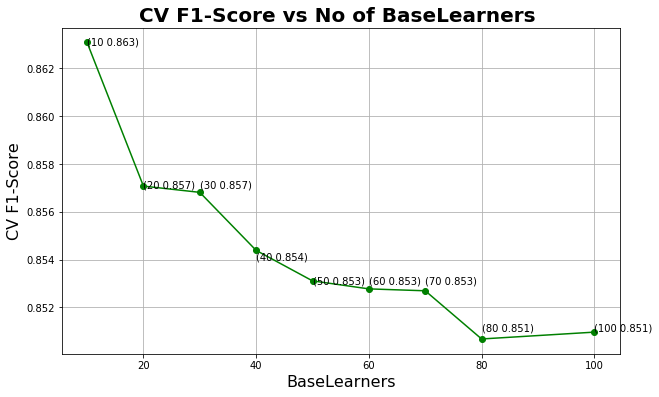

In [14]:
%%time
grid_estimator = RF_model(X_train_bowuni, y_train)

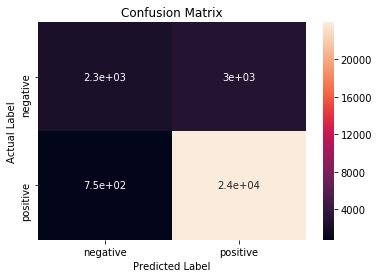

[[ 2338  2958]
 [  746 23958]]

Test Error : 0.123
Test Accuracy : 87.653 %
True Negative : 2338
False Positive : 2958
False Negative : 746
True Positive : 23958
Precission Score : 0.867
Recall Score : 0.877
F1 Score : 0.863



Classification Report for Model is :
             precision    recall  f1-score   support

   negative       0.76      0.44      0.56      5296
   positive       0.89      0.97      0.93     24704

avg / total       0.87      0.88      0.86     30000

CPU times: user 2.14 s, sys: 12 ms, total: 2.15 s
Wall time: 2.15 s


In [15]:
%%time
RF_Test(X_test_bowuni,y_test) 

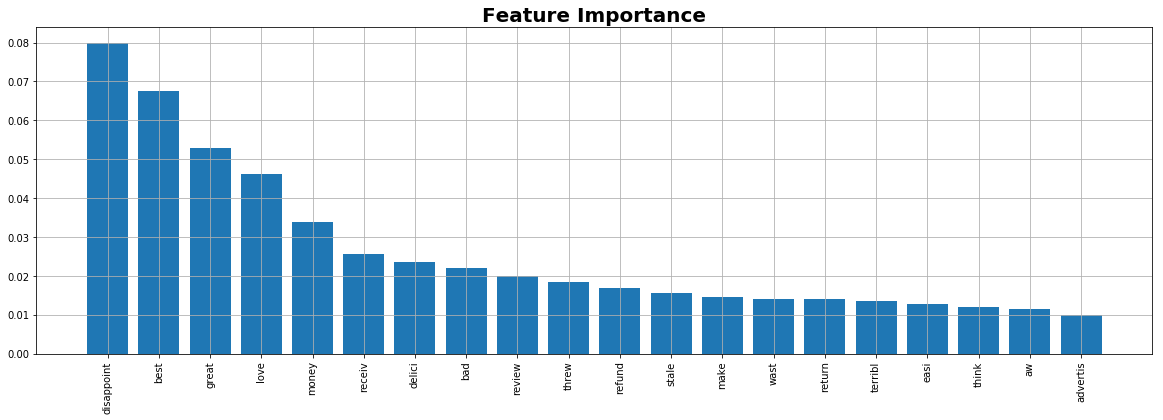

CPU times: user 1.06 s, sys: 8 ms, total: 1.07 s
Wall time: 1.07 s


In [20]:
%%time
featureimportance(X_train_bowuni, y_train,10,bow_unigram)

#### [8.1.2] XG Boost :

In [12]:
%%time
random_estimator = XGB_model(X_train_bowuni, y_train)


Grid Scores for Model is:
 [mean: 0.80644, std: 0.01509, params: {'learning_rate': 0.06668360836629884, 'max_depth': 2, 'n_estimators': 108}, mean: 0.84430, std: 0.00891, params: {'learning_rate': 0.06799300292669126, 'max_depth': 3, 'n_estimators': 180}, mean: 0.77916, std: 0.02652, params: {'learning_rate': 0.0654438087041719, 'max_depth': 1, 'n_estimators': 16}, mean: 0.78029, std: 0.02580, params: {'learning_rate': 0.08886350897510405, 'max_depth': 2, 'n_estimators': 10}, mean: 0.78126, std: 0.02576, params: {'learning_rate': 0.24065436138139162, 'max_depth': 1, 'n_estimators': 14}, mean: 0.85244, std: 0.01080, params: {'learning_rate': 0.4914024104034224, 'max_depth': 1, 'n_estimators': 76}, mean: 0.86488, std: 0.00903, params: {'learning_rate': 0.4803253730117049, 'max_depth': 3, 'n_estimators': 40}, mean: 0.87344, std: 0.00735, params: {'learning_rate': 0.3860620927908864, 'max_depth': 4, 'n_estimators': 53}, mean: 0.88192, std: 0.00710, params: {'learning_rate': 0.398168632230

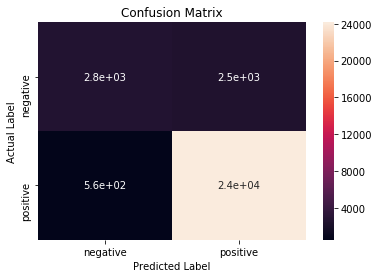

[[ 2761  2535]
 [  556 24148]]

Test Error : 0.103
Test Accuracy : 89.697 %
True Negative : 2761
False Positive : 2535
False Negative : 556
True Positive : 24148
Precission Score : 0.892
Recall Score : 0.897
F1 Score : 0.887



Classification Report for Model is :
             precision    recall  f1-score   support

   negative       0.83      0.52      0.64      5296
   positive       0.90      0.98      0.94     24704

avg / total       0.89      0.90      0.89     30000

CPU times: user 2.5 s, sys: 28 ms, total: 2.53 s
Wall time: 2.52 s


In [13]:
%%time
XGB_Test(X_test_bowuni,y_test)

### [8.2] Bag Of Words(bigram) : <a name="bowbi"></a>

In [9]:
%%time
bow_bigram = CountVectorizer(ngram_range=(1, 2),min_df=0.0005)
X_train_bowbi = bow_bigram.fit_transform(X_train)
print("Type of Count Vectorizer: ",type(X_train_bowbi))
print("The shape of text BOW vectorizer: ", X_train_bowbi.get_shape())
print("Number of unique word: ", X_train_bowbi.get_shape()[1])

Type of Count Vectorizer:  <class 'scipy.sparse.csr.csr_matrix'>
The shape of text BOW vectorizer:  (70000, 10992)
Number of unique word:  10992
CPU times: user 10.5 s, sys: 132 ms, total: 10.6 s
Wall time: 10.6 s


In [10]:
%%time
X_test_bowbi = bow_bigram.transform(X_test)
print("The shape of text BOW vectorizer: ", X_test_bowbi.get_shape())
print("Number of unique word: ", X_test_bowbi.get_shape()[1])

The shape of text BOW vectorizer:  (30000, 10992)
Number of unique word:  10992
CPU times: user 2.92 s, sys: 4 ms, total: 2.92 s
Wall time: 2.92 s


In [11]:
print("Shape of Training Data: ",X_train_bowbi.shape)
print("Shape of Test Data: ",X_test_bowbi.shape)

Shape of Training Data:  (70000, 10992)
Shape of Test Data:  (30000, 10992)


#### [8.2.1] Random Forest :


Grid Scores for Model is:
 [mean: 0.86993, std: 0.00702, params: {'n_estimators': 10}, mean: 0.86620, std: 0.00900, params: {'n_estimators': 20}, mean: 0.86539, std: 0.00993, params: {'n_estimators': 30}, mean: 0.86294, std: 0.00967, params: {'n_estimators': 40}, mean: 0.86178, std: 0.01020, params: {'n_estimators': 50}, mean: 0.86097, std: 0.00937, params: {'n_estimators': 60}, mean: 0.86040, std: 0.01030, params: {'n_estimators': 70}, mean: 0.85959, std: 0.01052, params: {'n_estimators': 80}, mean: 0.85894, std: 0.01117, params: {'n_estimators': 100}]

Best Parameters:  {'n_estimators': 10}

Best F1-Score: 0.87 
CPU times: user 1h 1min 43s, sys: 1.1 s, total: 1h 1min 44s
Wall time: 1h 1min 44s


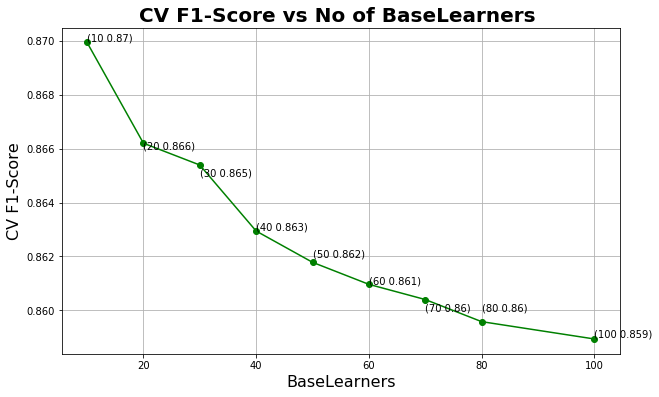

In [24]:
%%time
grid_estimator = RF_model(X_train_bowbi, y_train)

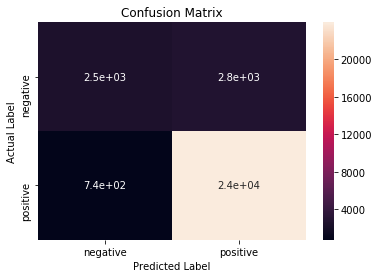

[[ 2502  2794]
 [  744 23960]]

Test Error : 0.118
Test Accuracy : 88.207 %
True Negative : 2502
False Positive : 2794
False Negative : 744
True Positive : 23960
Precission Score : 0.874
Recall Score : 0.882
F1 Score : 0.87



Classification Report for Model is :
             precision    recall  f1-score   support

   negative       0.77      0.47      0.59      5296
   positive       0.90      0.97      0.93     24704

avg / total       0.87      0.88      0.87     30000

CPU times: user 2.2 s, sys: 4 ms, total: 2.2 s
Wall time: 2.2 s


In [25]:
%%time
RF_Test(X_test_bowbi,y_test)

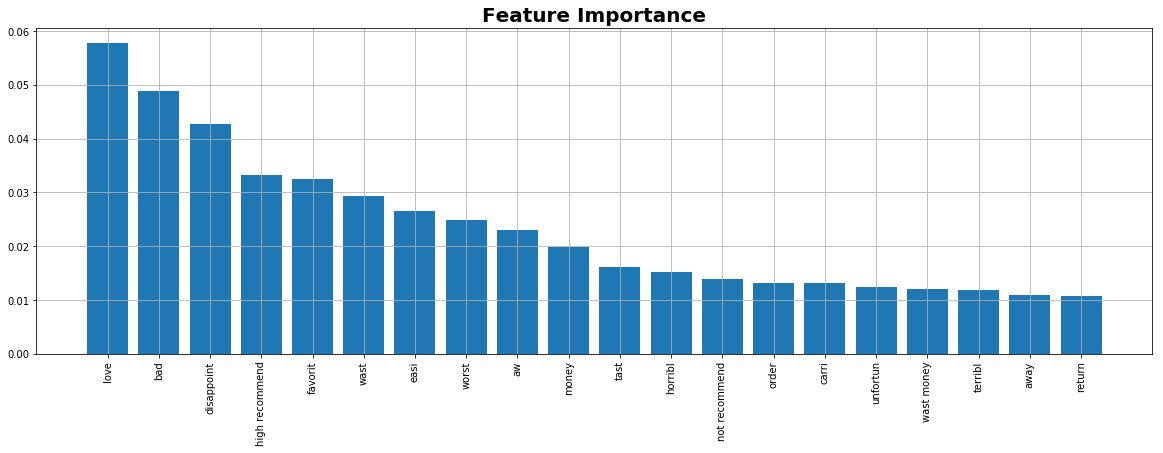

CPU times: user 1.12 s, sys: 12 ms, total: 1.13 s
Wall time: 1.06 s


In [12]:
%%time
featureimportance(X_train_bowbi, y_train,10,bow_bigram)

#### [8.2.2] XG Boost :

In [27]:
%%time
random_estimator = XGB_model(X_train_bowbi, y_train)


Grid Scores for Model is:
 [mean: 0.90417, std: 0.00660, params: {'learning_rate': 0.4002353878126803, 'max_depth': 4, 'n_estimators': 193}, mean: 0.87037, std: 0.00681, params: {'learning_rate': 0.08997932166986629, 'max_depth': 4, 'n_estimators': 170}, mean: 0.89803, std: 0.00616, params: {'learning_rate': 0.2568979843529595, 'max_depth': 4, 'n_estimators': 187}, mean: 0.90015, std: 0.00579, params: {'learning_rate': 0.5437151482553318, 'max_depth': 2, 'n_estimators': 196}, mean: 0.87302, std: 0.00844, params: {'learning_rate': 0.5402623804152094, 'max_depth': 2, 'n_estimators': 51}, mean: 0.80409, std: 0.01797, params: {'learning_rate': 0.28608081689708253, 'max_depth': 4, 'n_estimators': 4}, mean: 0.84448, std: 0.00975, params: {'learning_rate': 0.26752627839555604, 'max_depth': 4, 'n_estimators': 24}, mean: 0.89964, std: 0.00690, params: {'learning_rate': 0.5440893217185155, 'max_depth': 3, 'n_estimators': 129}, mean: 0.89353, std: 0.00574, params: {'learning_rate': 0.46307626547

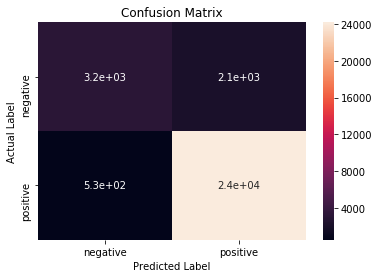

[[ 3170  2126]
 [  533 24171]]

Test Error : 0.089
Test Accuracy : 91.137 %
True Negative : 3170
False Positive : 2126
False Negative : 533
True Positive : 24171
Precission Score : 0.908
Recall Score : 0.911
F1 Score : 0.905



Classification Report for Model is :
             precision    recall  f1-score   support

   negative       0.86      0.60      0.70      5296
   positive       0.92      0.98      0.95     24704

avg / total       0.91      0.91      0.90     30000

CPU times: user 2.68 s, sys: 8 ms, total: 2.69 s
Wall time: 2.69 s


In [28]:
%%time
XGB_Test(X_test_bowbi,y_test)

### [8.3] TF-IDF(unigram) : <a name="tfidfuni"></a>

In [13]:
%%time
tfidf_unigram = TfidfVectorizer(min_df = 0.0005)
X_train_tfidfuni = tfidf_unigram.fit_transform(X_train)
print("Type of Count Vectorizer: ",type(X_train_tfidfuni))
print("The shape of text TFIDF vectorizer: ", X_train_tfidfuni.get_shape())
print("Number of unique word: ", X_train_tfidfuni.get_shape()[1])

Type of Count Vectorizer:  <class 'scipy.sparse.csr.csr_matrix'>
The shape of text TFIDF vectorizer:  (70000, 3907)
Number of unique word:  3907
CPU times: user 3.26 s, sys: 0 ns, total: 3.26 s
Wall time: 3.26 s


In [14]:
%%time
X_test_tfidfuni = tfidf_unigram.transform(X_test)
print("The shape of text TFIDF vectorizer: ", X_test_tfidfuni.get_shape())
print("Number of unique word: ", X_test_tfidfuni.get_shape()[1])

The shape of text TFIDF vectorizer:  (30000, 3907)
Number of unique word:  3907
CPU times: user 1.54 s, sys: 4 ms, total: 1.54 s
Wall time: 1.54 s


In [15]:
print("Shape of Training Data: ",X_train_tfidfuni.shape)
print("Shape of Test Data: ",X_test_tfidfuni.shape)

Shape of Training Data:  (70000, 3907)
Shape of Test Data:  (30000, 3907)


#### [8.3.1] Random Forest :


Grid Scores for Model is:
 [mean: 0.86489, std: 0.00728, params: {'n_estimators': 10}, mean: 0.85947, std: 0.00822, params: {'n_estimators': 20}, mean: 0.85500, std: 0.00761, params: {'n_estimators': 30}, mean: 0.85431, std: 0.00897, params: {'n_estimators': 40}, mean: 0.85223, std: 0.00864, params: {'n_estimators': 50}, mean: 0.85333, std: 0.00880, params: {'n_estimators': 60}, mean: 0.85267, std: 0.00916, params: {'n_estimators': 70}, mean: 0.85241, std: 0.00988, params: {'n_estimators': 80}, mean: 0.85192, std: 0.00774, params: {'n_estimators': 100}]

Best Parameters:  {'n_estimators': 10}

Best F1-Score: 0.865 
CPU times: user 54min 21s, sys: 344 ms, total: 54min 21s
Wall time: 54min 21s


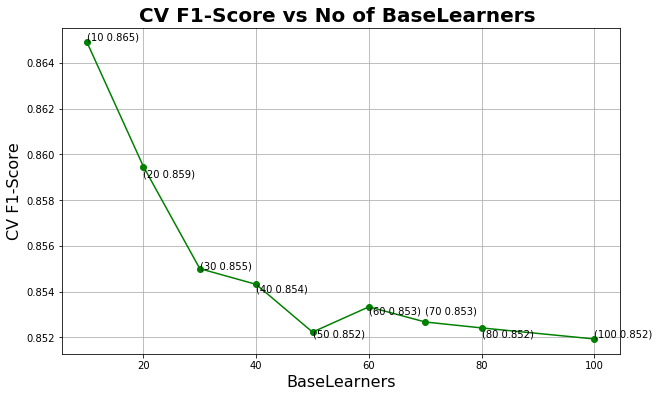

In [33]:
%%time
grid_estimator = RF_model(X_train_tfidfuni, y_train)

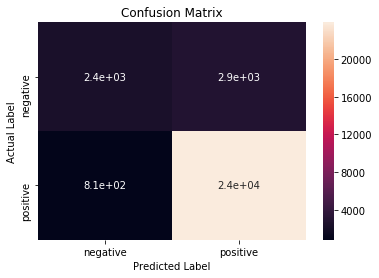

[[ 2371  2925]
 [  809 23895]]

Test Error : 0.124
Test Accuracy : 87.553 %
True Negative : 2371
False Positive : 2925
False Negative : 809
True Positive : 23895
Precission Score : 0.865
Recall Score : 0.876
F1 Score : 0.863



Classification Report for Model is :
             precision    recall  f1-score   support

   negative       0.75      0.45      0.56      5296
   positive       0.89      0.97      0.93     24704

avg / total       0.87      0.88      0.86     30000

CPU times: user 2.16 s, sys: 8 ms, total: 2.17 s
Wall time: 2.16 s


In [34]:
%%time
RF_Test(X_test_tfidfuni,y_test)

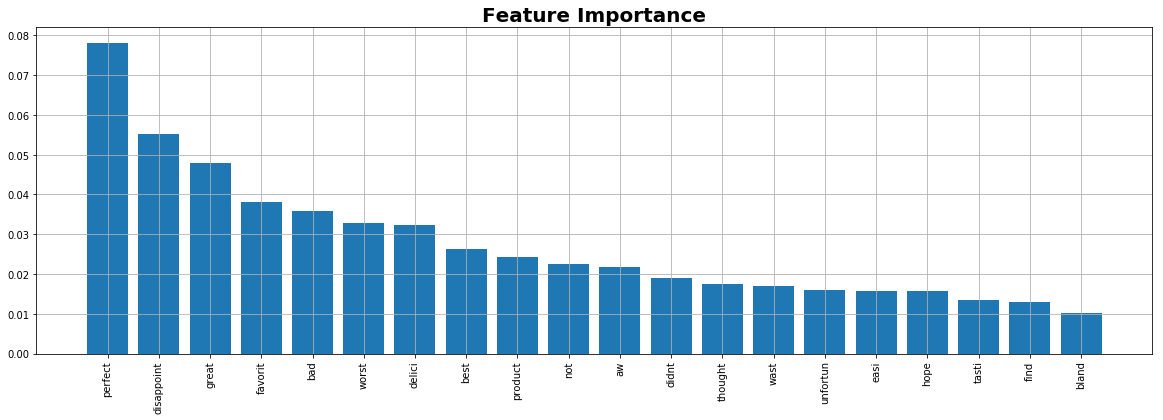

CPU times: user 1.4 s, sys: 16 ms, total: 1.41 s
Wall time: 1.33 s


In [16]:
%%time
featureimportance(X_train_tfidfuni, y_train,10,tfidf_unigram)

#### [8.3.2] XG Boost :

In [35]:
%%time
random_estimator = XGB_model(X_train_tfidfuni, y_train)


Grid Scores for Model is:
 [mean: 0.81616, std: 0.01485, params: {'learning_rate': 0.11468164769367468, 'max_depth': 1, 'n_estimators': 156}, mean: 0.88597, std: 0.00745, params: {'learning_rate': 0.37997386892353996, 'max_depth': 4, 'n_estimators': 95}, mean: 0.85434, std: 0.00881, params: {'learning_rate': 0.3904339237898107, 'max_depth': 3, 'n_estimators': 34}, mean: 0.88564, std: 0.00790, params: {'learning_rate': 0.4138275398055624, 'max_depth': 2, 'n_estimators': 161}, mean: 0.87461, std: 0.00800, params: {'learning_rate': 0.194777008177086, 'max_depth': 3, 'n_estimators': 146}, mean: 0.80907, std: 0.01731, params: {'learning_rate': 0.28179495659688353, 'max_depth': 1, 'n_estimators': 42}, mean: 0.88939, std: 0.00726, params: {'learning_rate': 0.3423200842906201, 'max_depth': 4, 'n_estimators': 127}, mean: 0.87897, std: 0.00733, params: {'learning_rate': 0.46615737176463273, 'max_depth': 2, 'n_estimators': 98}, mean: 0.82245, std: 0.01411, params: {'learning_rate': 0.32773611342

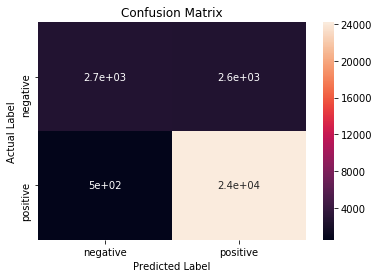

[[ 2686  2610]
 [  497 24207]]

Test Error : 0.104
Test Accuracy : 89.643 %
True Negative : 2686
False Positive : 2610
False Negative : 497
True Positive : 24207
Precission Score : 0.892
Recall Score : 0.896
F1 Score : 0.886



Classification Report for Model is :
             precision    recall  f1-score   support

   negative       0.84      0.51      0.63      5296
   positive       0.90      0.98      0.94     24704

avg / total       0.89      0.90      0.89     30000

CPU times: user 2.47 s, sys: 16 ms, total: 2.48 s
Wall time: 2.48 s


In [36]:
%%time
XGB_Test(X_test_tfidfuni,y_test)

### [8.4] TF-IDF(bigram) : <a name="tfidfbi"></a>

In [17]:
%%time
tfidf_bigram = TfidfVectorizer(ngram_range=(1, 2),min_df = 0.0005)
X_train_tfidfbi = tfidf_bigram.fit_transform(X_train)
print("Type of Count Vectorizer: ",type(X_train_tfidfbi))
print("The shape of text TFIDF vectorizer: ", X_train_tfidfbi.get_shape())
print("Number of unique word: ", X_train_tfidfbi.get_shape()[1])

Type of Count Vectorizer:  <class 'scipy.sparse.csr.csr_matrix'>
The shape of text TFIDF vectorizer:  (70000, 10992)
Number of unique word:  10992
CPU times: user 10.5 s, sys: 136 ms, total: 10.7 s
Wall time: 10.7 s


In [18]:
%%time
X_test_tfidfbi = tfidf_bigram.transform(X_test)
print("The shape of text TFIDF vectorizer: ", X_test_tfidfbi.get_shape())
print("Number of unique word: ", X_test_tfidfbi.get_shape()[1])

The shape of text TFIDF vectorizer:  (30000, 10992)
Number of unique word:  10992
CPU times: user 2.98 s, sys: 0 ns, total: 2.98 s
Wall time: 2.97 s


In [19]:
print("Shape of Training Data: ",X_train_tfidfbi.shape)
print("Shape of Test Data: ",X_test_tfidfbi.shape)

Shape of Training Data:  (70000, 10992)
Shape of Test Data:  (30000, 10992)


#### [8.4.1] Random Forest :


Grid Scores for Model is:
 [mean: 0.86754, std: 0.00797, params: {'n_estimators': 10}, mean: 0.86258, std: 0.00989, params: {'n_estimators': 20}, mean: 0.86121, std: 0.00942, params: {'n_estimators': 30}, mean: 0.85962, std: 0.00987, params: {'n_estimators': 40}, mean: 0.85748, std: 0.01070, params: {'n_estimators': 50}, mean: 0.85655, std: 0.01271, params: {'n_estimators': 60}, mean: 0.85677, std: 0.01187, params: {'n_estimators': 70}, mean: 0.85571, std: 0.01240, params: {'n_estimators': 80}, mean: 0.85422, std: 0.01166, params: {'n_estimators': 100}]

Best Parameters:  {'n_estimators': 10}

Best F1-Score: 0.868 
CPU times: user 55min 42s, sys: 328 ms, total: 55min 42s
Wall time: 55min 43s


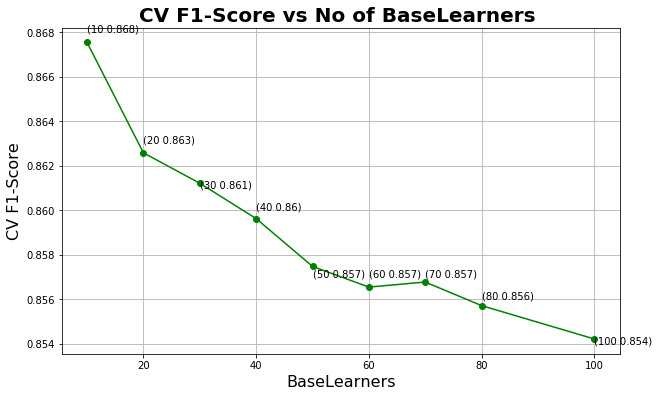

In [20]:
%%time
grid_estimator = RF_model(X_train_tfidfbi, y_train)

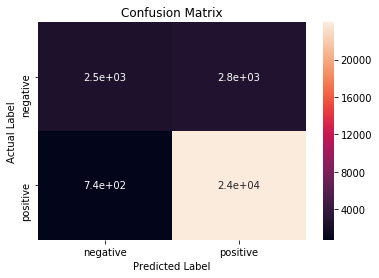

[[ 2545  2751]
 [  735 23969]]

Test Error : 0.116
Test Accuracy : 88.38 %
True Negative : 2545
False Positive : 2751
False Negative : 735
True Positive : 23969
Precission Score : 0.876
Recall Score : 0.884
F1 Score : 0.872



Classification Report for Model is :
             precision    recall  f1-score   support

   negative       0.78      0.48      0.59      5296
   positive       0.90      0.97      0.93     24704

avg / total       0.88      0.88      0.87     30000

CPU times: user 2.52 s, sys: 4 ms, total: 2.52 s
Wall time: 2.27 s


In [21]:
%%time
RF_Test(X_test_tfidfbi,y_test)

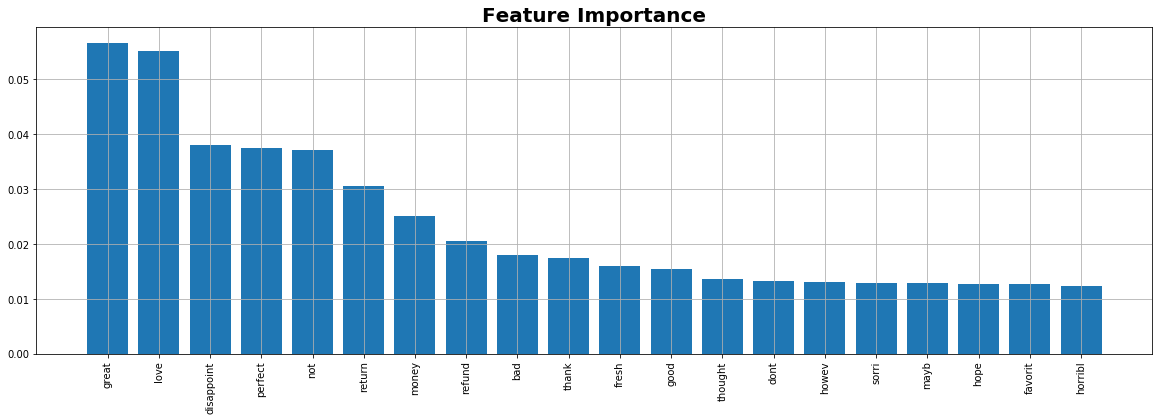

CPU times: user 1.31 s, sys: 12 ms, total: 1.32 s
Wall time: 1.21 s


In [22]:
%%time
featureimportance(X_train_tfidfbi, y_train,10,tfidf_bigram)

#### [8.4.2] XG Boost :

In [23]:
%%time
random_estimator = XGB_model(X_train_tfidfbi, y_train)


Grid Scores for Model is:
 [mean: 0.89753, std: 0.00809, params: {'learning_rate': 0.25178966441947087, 'max_depth': 4, 'n_estimators': 180}, mean: 0.89441, std: 0.00709, params: {'learning_rate': 0.32483875522951977, 'max_depth': 3, 'n_estimators': 153}, mean: 0.87425, std: 0.00901, params: {'learning_rate': 0.46834934918484555, 'max_depth': 1, 'n_estimators': 132}, mean: 0.89856, std: 0.00827, params: {'learning_rate': 0.48519292400276026, 'max_depth': 3, 'n_estimators': 128}, mean: 0.90252, std: 0.00699, params: {'learning_rate': 0.4910869994505028, 'max_depth': 3, 'n_estimators': 171}, mean: 0.87139, std: 0.00784, params: {'learning_rate': 0.3131972305306965, 'max_depth': 4, 'n_estimators': 45}, mean: 0.82672, std: 0.01263, params: {'learning_rate': 0.4488556702105684, 'max_depth': 4, 'n_estimators': 7}, mean: 0.87294, std: 0.00742, params: {'learning_rate': 0.4408239090832846, 'max_depth': 3, 'n_estimators': 41}, mean: 0.88453, std: 0.00653, params: {'learning_rate': 0.3897203233

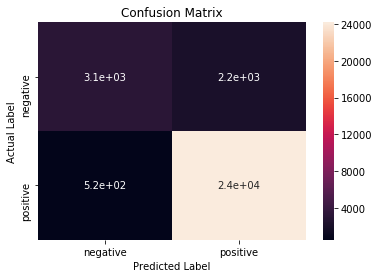

[[ 3124  2172]
 [  515 24189]]

Test Error : 0.09
Test Accuracy : 91.043 %
True Negative : 3124
False Positive : 2172
False Negative : 515
True Positive : 24189
Precission Score : 0.907
Recall Score : 0.91
F1 Score : 0.904



Classification Report for Model is :
             precision    recall  f1-score   support

   negative       0.86      0.59      0.70      5296
   positive       0.92      0.98      0.95     24704

avg / total       0.91      0.91      0.90     30000

CPU times: user 2.65 s, sys: 12 ms, total: 2.66 s
Wall time: 2.65 s


In [24]:
%%time
XGB_Test(X_test_tfidfbi,y_test)

## [8.5] Average Word2Vec : <a name="avgw2v"></a>

In [9]:
i=0
list_of_sent_train=[]
for sent in X_train:
    list_of_sent_train.append(sent.split())

In [10]:
print(X_train[0])
print("****************************************************************************")
print(list_of_sent_train[0])

beetlejuic excel funni movi keaton hilari wacki beetlejuic great special effect help film think one best movi ever made sure youll agre good time watch beetlejuic
****************************************************************************
['beetlejuic', 'excel', 'funni', 'movi', 'keaton', 'hilari', 'wacki', 'beetlejuic', 'great', 'special', 'effect', 'help', 'film', 'think', 'one', 'best', 'movi', 'ever', 'made', 'sure', 'youll', 'agre', 'good', 'time', 'watch', 'beetlejuic']


In [11]:
%%time
## Word2Vec Model considering only those words that occur atleast 5 times in the corpus
min_count = 5
w2v_model = Word2Vec(list_of_sent_train, min_count = min_count, size = 200, workers = 4)
w2v_words = list(w2v_model.wv.vocab)

CPU times: user 58.2 s, sys: 100 ms, total: 58.3 s
Wall time: 16 s


In [12]:
w2v_words = list(w2v_model.wv.vocab)

In [13]:
i=0
list_of_sent_test=[]
for sent in X_test:
    list_of_sent_test.append(sent.split())

In [14]:
print(X_test[5])
print("****************************************************************************")
print(list_of_sent_test[5])

overpow point slight nauseat strawberri flavor smell chemic even though suppos natur
****************************************************************************
['overpow', 'point', 'slight', 'nauseat', 'strawberri', 'flavor', 'smell', 'chemic', 'even', 'though', 'suppos', 'natur']


In [31]:
%%time
X_train_avgw2v = [] # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sent_train):
    sent_vec = np.zeros(200) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    X_train_avgw2v.append(sent_vec)

100%|██████████| 70000/70000 [01:45<00:00, 664.67it/s]

CPU times: user 1min 45s, sys: 1.66 s, total: 1min 46s
Wall time: 1min 45s


In [32]:
%%time
X_test_avgw2v = [] # the avg-w2v for each sentence/review is stored in this list
for sent in tqdm(list_of_sent_test):
    sent_vec = np.zeros(200) # as word vectors are of zero length
    cnt_words =0; # num of words with a valid vector in the sentence/review
    for word in sent: # for each word in a review/sentence
        if word in w2v_words:
            vec = w2v_model.wv[word]
            sent_vec += vec
            cnt_words += 1
    if cnt_words != 0:
        sent_vec /= cnt_words
    X_test_avgw2v.append(sent_vec)

100%|██████████| 30000/30000 [00:48<00:00, 618.78it/s]

CPU times: user 48.4 s, sys: 820 ms, total: 49.2 s
Wall time: 48.5 s


In [33]:
#Checking NAN in test data if any
np.any(np.isnan(X_test_avgw2v))

False

In [34]:
print("Number of rows in Train Data: ",len(X_train_avgw2v))
print("Number of features in Train Data: ",len(X_train_avgw2v[0]))
print("Number of rows in Test Data: ",len(X_test_avgw2v))
print("Number of features in Test Data: ",len(X_test_avgw2v[0]))

Number of rows in Train Data:  70000
Number of features in Train Data:  200
Number of rows in Test Data:  30000
Number of features in Test Data:  200


#### [8.5.1] Random Forest :


Grid Scores for Model is:
 [mean: 0.85197, std: 0.00872, params: {'n_estimators': 10}, mean: 0.84844, std: 0.00917, params: {'n_estimators': 20}, mean: 0.84600, std: 0.00950, params: {'n_estimators': 30}, mean: 0.84573, std: 0.00938, params: {'n_estimators': 40}, mean: 0.84443, std: 0.01044, params: {'n_estimators': 50}, mean: 0.84552, std: 0.00996, params: {'n_estimators': 60}, mean: 0.84444, std: 0.01014, params: {'n_estimators': 70}, mean: 0.84453, std: 0.01066, params: {'n_estimators': 80}, mean: 0.84433, std: 0.00999, params: {'n_estimators': 100}]

Best Parameters:  {'n_estimators': 10}

Best F1-Score: 0.852 
CPU times: user 49min 34s, sys: 504 ms, total: 49min 35s
Wall time: 49min 35s


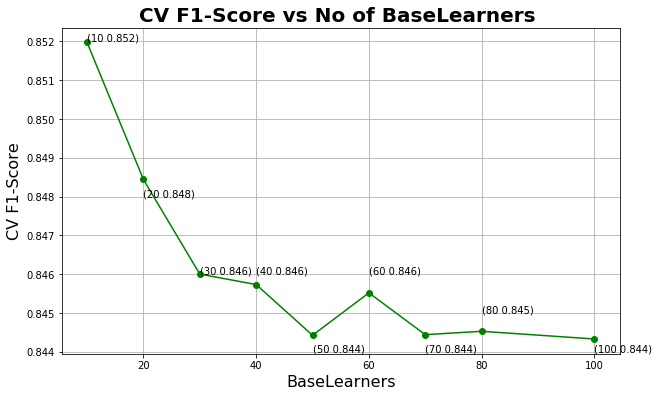

In [35]:
%%time
grid_estimator = RF_model(X_train_avgw2v,y_train)

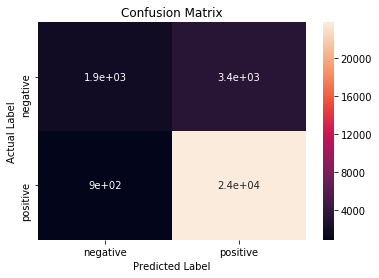

[[ 1940  3356]
 [  896 23808]]

Test Error : 0.142
Test Accuracy : 85.827 %
True Negative : 1940
False Positive : 3356
False Negative : 896
True Positive : 23808
Precission Score : 0.842
Recall Score : 0.858
F1 Score : 0.84



Classification Report for Model is :
             precision    recall  f1-score   support

   negative       0.68      0.37      0.48      5296
   positive       0.88      0.96      0.92     24704

avg / total       0.84      0.86      0.84     30000

CPU times: user 2.18 s, sys: 4 ms, total: 2.19 s
Wall time: 2.18 s


In [36]:
%%time
RF_Test(X_test_avgw2v,y_test)

#### [8.5.2] XG Boost :

In [37]:
%%time
X_train_avgw2v = np.array(X_train_avgw2v)
X_test_avgw2v = np.array(X_test_avgw2v)
random_estimator = XGB_model(X_train_avgw2v,y_train)


Grid Scores for Model is:
 [mean: 0.88798, std: 0.00615, params: {'learning_rate': 0.27216725610998643, 'max_depth': 4, 'n_estimators': 83}, mean: 0.77916, std: 0.02652, params: {'learning_rate': 0.05261647072918803, 'max_depth': 1, 'n_estimators': 71}, mean: 0.88604, std: 0.00586, params: {'learning_rate': 0.50458908342728, 'max_depth': 4, 'n_estimators': 79}, mean: 0.88755, std: 0.00750, params: {'learning_rate': 0.4717464764704802, 'max_depth': 3, 'n_estimators': 93}, mean: 0.85864, std: 0.01084, params: {'learning_rate': 0.12052289170778548, 'max_depth': 3, 'n_estimators': 45}, mean: 0.89038, std: 0.00746, params: {'learning_rate': 0.3665145670483816, 'max_depth': 3, 'n_estimators': 193}, mean: 0.86438, std: 0.01025, params: {'learning_rate': 0.11288274464101562, 'max_depth': 2, 'n_estimators': 90}, mean: 0.88384, std: 0.00695, params: {'learning_rate': 0.09655411544597182, 'max_depth': 4, 'n_estimators': 119}, mean: 0.87150, std: 0.00832, params: {'learning_rate': 0.0939622102210

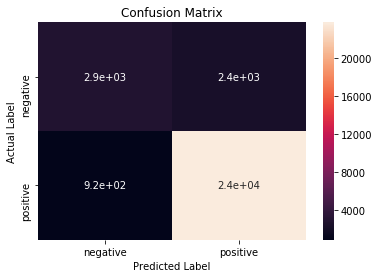

[[ 2936  2360]
 [  917 23787]]

Test Error : 0.109
Test Accuracy : 89.077 %
True Negative : 2936
False Positive : 2360
False Negative : 917
True Positive : 23787
Precission Score : 0.884
Recall Score : 0.891
F1 Score : 0.884



Classification Report for Model is :
             precision    recall  f1-score   support

   negative       0.76      0.55      0.64      5296
   positive       0.91      0.96      0.94     24704

avg / total       0.88      0.89      0.88     30000

CPU times: user 2.31 s, sys: 16 ms, total: 2.32 s
Wall time: 2.32 s


In [38]:
%%time
XGB_Test(X_test_avgw2v,y_test)

## [8.6] TF-IDF Weighted Word2Vec : <a name="tfidfw2v"></a>

In [15]:
%%time
tfidf = TfidfVectorizer(ngram_range=(1, 2))
tfidf_vectors = tfidf.fit_transform(X_train)

CPU times: user 11.1 s, sys: 212 ms, total: 11.3 s
Wall time: 11.3 s


In [16]:
dictionary = dict(zip(tfidf.get_feature_names(),list(tfidf.idf_)))
print(len(dictionary))

968796


In [17]:
%%time
tfidf_feat = tfidf.get_feature_names() # tfidf words/col-names
X_train_tfidfw2v = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sent_train):
    sent_vec = np.zeros(200)
    weight_sum =0;
    for word in sent:
        if word in w2v_words:
            vec = w2v_model.wv[word]
            tf_idf = dictionary[word]*sent.count(word)
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    X_train_tfidfw2v.append(sent_vec)
    row += 1

100%|██████████| 70000/70000 [02:05<00:00, 557.10it/s]

CPU times: user 2min 7s, sys: 4.3 s, total: 2min 11s
Wall time: 2min 7s


In [18]:
%%time
X_test_tfidfw2v = []; # the tfidf-w2v for each sentence/review is stored in this list
row=0;
for sent in tqdm(list_of_sent_test):
    sent_vec = np.zeros(200)
    weight_sum =0;
    for word in sent:
        if word in w2v_words:
            vec = w2v_model.wv[word]
            tf_idf = dictionary[word]*sent.count(word)
            sent_vec += (vec * tf_idf)
            weight_sum += tf_idf
    if weight_sum != 0:
        sent_vec /= weight_sum
    X_test_tfidfw2v.append(sent_vec)
    row += 1

100%|██████████| 30000/30000 [00:57<00:00, 523.50it/s]

CPU times: user 57.3 s, sys: 2.32 s, total: 59.6 s
Wall time: 57.3 s


In [19]:
print("Number of rows in Train Data: ",len(X_train_tfidfw2v))
print("Number of features in Train Data: ",len(X_train_tfidfw2v[0]))
print("Number of rows in Test Data: ",len(X_test_tfidfw2v))
print("Number of features in Test Data: ",len(X_test_tfidfw2v[0]))

Number of rows in Train Data:  70000
Number of features in Train Data:  200
Number of rows in Test Data:  30000
Number of features in Test Data:  200


#### [8.6.1] Random Forest :


Grid Scores for Model is:
 [mean: 0.83924, std: 0.01154, params: {'n_estimators': 10}, mean: 0.83582, std: 0.01151, params: {'n_estimators': 20}, mean: 0.83306, std: 0.01267, params: {'n_estimators': 30}, mean: 0.83202, std: 0.01220, params: {'n_estimators': 40}, mean: 0.83085, std: 0.01232, params: {'n_estimators': 50}, mean: 0.83048, std: 0.01189, params: {'n_estimators': 60}, mean: 0.83036, std: 0.01301, params: {'n_estimators': 70}, mean: 0.82946, std: 0.01207, params: {'n_estimators': 80}, mean: 0.82950, std: 0.01221, params: {'n_estimators': 100}]

Best Parameters:  {'n_estimators': 10}

Best F1-Score: 0.839 
CPU times: user 49min 46s, sys: 408 ms, total: 49min 47s
Wall time: 49min 47s


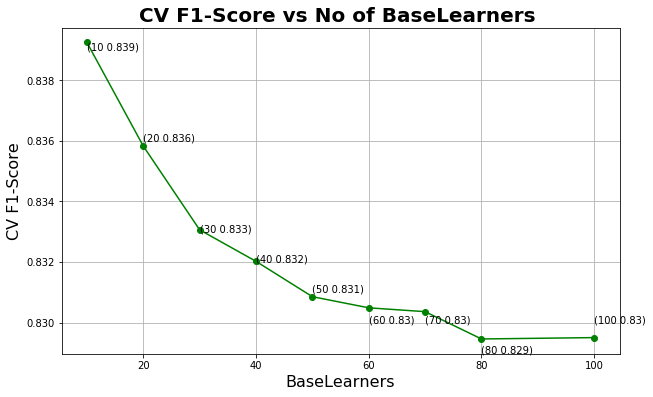

In [44]:
%%time
grid_estimator=RF_model(X_train_tfidfw2v,y_train)

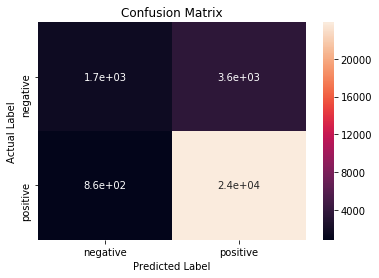

[[ 1687  3609]
 [  855 23849]]

Test Error : 0.149
Test Accuracy : 85.12 %
True Negative : 1687
False Positive : 3609
False Negative : 855
True Positive : 23849
Precission Score : 0.832
Recall Score : 0.851
F1 Score : 0.829



Classification Report for Model is :
             precision    recall  f1-score   support

   negative       0.66      0.32      0.43      5296
   positive       0.87      0.97      0.91     24704

avg / total       0.83      0.85      0.83     30000

CPU times: user 2.18 s, sys: 20 ms, total: 2.2 s
Wall time: 2.2 s


In [45]:
%%time
RF_Test(X_test_tfidfw2v, y_test) 

#### [8.6.2] XG Boost :

In [20]:
%%time
X_train_tfidfw2v = np.array(X_train_tfidfw2v)
X_test_tfidfw2v = np.array(X_test_tfidfw2v)
random_estimator=XGB_model(X_train_tfidfw2v,y_train)


Grid Scores for Model is:
 [mean: 0.84073, std: 0.01342, params: {'learning_rate': 0.5232368888776844, 'max_depth': 3, 'n_estimators': 9}, mean: 0.83370, std: 0.01349, params: {'learning_rate': 0.37533771588509884, 'max_depth': 2, 'n_estimators': 16}, mean: 0.86987, std: 0.00859, params: {'learning_rate': 0.31307003190533916, 'max_depth': 2, 'n_estimators': 182}, mean: 0.83667, std: 0.01346, params: {'learning_rate': 0.31582975218074916, 'max_depth': 1, 'n_estimators': 57}, mean: 0.86508, std: 0.00950, params: {'learning_rate': 0.22690987966728288, 'max_depth': 2, 'n_estimators': 161}, mean: 0.86303, std: 0.01208, params: {'learning_rate': 0.5028992699476139, 'max_depth': 1, 'n_estimators': 143}, mean: 0.87277, std: 0.00829, params: {'learning_rate': 0.34198272429360455, 'max_depth': 3, 'n_estimators': 134}, mean: 0.86996, std: 0.00904, params: {'learning_rate': 0.5246179731780988, 'max_depth': 2, 'n_estimators': 123}, mean: 0.86506, std: 0.01017, params: {'learning_rate': 0.474818111

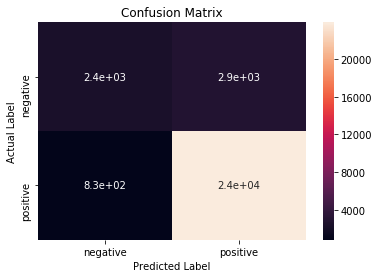

[[ 2387  2909]
 [  829 23875]]

Test Error : 0.125
Test Accuracy : 87.54 %
True Negative : 2387
False Positive : 2909
False Negative : 829
True Positive : 23875
Precission Score : 0.865
Recall Score : 0.875
F1 Score : 0.863



Classification Report for Model is :
             precision    recall  f1-score   support

   negative       0.74      0.45      0.56      5296
   positive       0.89      0.97      0.93     24704

avg / total       0.87      0.88      0.86     30000

CPU times: user 2.31 s, sys: 0 ns, total: 2.31 s
Wall time: 2.31 s


In [21]:
%%time
XGB_Test(X_test_tfidfw2v, y_test) 

## [9] Conclusion : <a name="conclusion"></a>

<b> Random Forest(Bagging) : </b>  

| Featurization Model | <b>Accuracy</b> | <b>Precission</b> | <b>Recall</b> | <b>F1 score</b> |  
| --- | --- | --- | --- | --- | --- | --- | --- | --- |  
| <b>BOW(unigram)</b> | 87.653 % | 0.867  | 0.877 | 0.863 |  
| <b>BOW(bigram)</b> | 88.207 % | 0.874  | 0.882 | 0.887 |  
| <b>TF-IDF(unigram)</b> | 87.553 % | 0.865  | 0.876 | 0.863 |  
| <b>TF-IDF(bigram)</b> | 88.38 % | 0.876  | 0.884 | 0.872 |  
| <b>Average Word2Vec</b> | 85.827 % | 0.842  | 0.858 | 0.84 |  
| <b>TF-IDF Weighted Word2Vec</b> | 85.12 % | 0.832  | 0.851 | 0.829 |  

<b> XG Boost(Gradient Boosting) : </b>  

| Featurization Model | <b>Accuracy</b> | <b>Precission</b> | <b>Recall</b> | <b>F1 score</b> |
| --- | --- | --- | --- | --- | --- | --- | --- | --- |
| <b>BOW(unigram)</b> | 89.697 % | 0.892  | 0.897 | 0.887 |
| <b>BOW(bigram)</b> | 91.137 % | 0.908  | 0.911 | 0.905 |
| <b>TF-IDF(unigram)</b> | 89.643 % | 0.892  | 0.896 | 0.886 |
| <b>TF-IDF(bigram)</b> | 91.043 % | 0.907  | 0.91 | 0.904 |
| <b>Average Word2Vec</b> | 89.077 % | 0.884  | 0.891 | 0.884 |
| <b>TF-IDF Weighted Word2Vec</b> | 87.54 % | 0.865  | 0.875 | 0.863 |


<b>1 - </b>It is observed that XGBoost(Gradient Boosting) performs fairly well in terms of performance metrics then RandomForest(Bootsrap sampling).

<b>2 - </b>Using BOW bigram  and Tfidf bigram, XGboost  gives best performance with F1 score of <b>0.905</b> and <b>0.904</b>.

<b>3 - </b>Run Time complexity of  both Random Forest and XGBoost is superfast, hence can be used for low latency applications.